<a href="https://colab.research.google.com/github/stefanosGerschKoutsogiannis/8_Puzzle_Extended/blob/main/facial-image-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data and do some preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np

def load_images_from_directory(filepath_to_folder):
    images = []
    for filename in os.listdir(filepath_to_folder):
        img = cv2.imread(os.path.join(filepath_to_folder, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (180, 180))
        # convert bgr to rgb
        rgb_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if rgb_im is not None:
            images.append(rgb_im)
    return np.array(images)

TRAIN_PLEASANT = "/content/drive/MyDrive/classification/data/train-images/train/pleasant"
TRAIN_UNPLEASANT = "/content/drive/MyDrive/classification/data/train-images/train/unpleasant"
TEST_IMAGES = "/content/drive/MyDrive/classification/data/TEST_images/TEST_images"

pleasant_images = load_images_from_directory(TRAIN_PLEASANT)
unpleasant_images = load_images_from_directory(TRAIN_UNPLEASANT)
test_images = load_images_from_directory(TEST_IMAGES)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(images):
  """
  Plots four images in a 6x6 subplot.

  Args:
    images: A list or tuple of four numpy arrays representing the images.
  """

  if len(images) != 36:
    raise ValueError("Expected 36 images, got {}".format(len(images)))

  fig, axes = plt.subplots(6, 6)

  for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.axis('off')  # Turn off axis labels and ticks

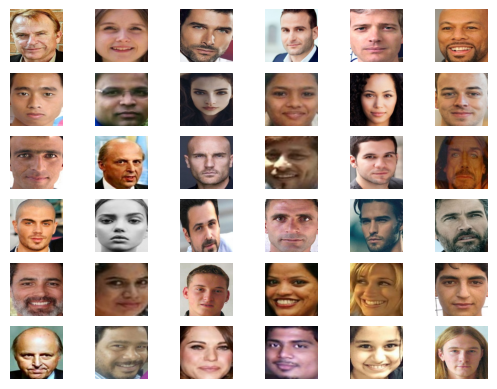

In [8]:
plot_images(pleasant_images[:36])

## Create train and test data

In [9]:
# X_train contains pleasant and unpleasant images
# y_train contains the labels

def image2vector(image):
    """
    Row-major flattening for images with shape (180, 180, 3).
    """
    return image.reshape(-1, order='C') #Flattens correctly for channels last.

def vectorize_images(images, label):
    """
    Vectorizes images with shape (3394, 180, 180, 3).
    """
    num_images = images.shape[0]
    image_size = images.shape[1] * images.shape[2] * images.shape[3]  # 180 * 180 * 3

    ret = np.empty((num_images, image_size + 1))

    for i in range(num_images):
        ret[i, :-1] = image2vector(images[i])
        ret[i, -1] = label

    return ret


def vector2image(vector, height, width, channels):
    """
    Reshapes a flattened vector back to (height, width, channels).
    """
    return vector.reshape((height, width, channels), order='C')

def devectorize_images(vectorized_images, height=180, width=180, channels=3):
    """
    Devectorizes images back to (num_images, height, width, channels).
    """
    num_images = vectorized_images.shape[0]
    labels = vectorized_images[:, -1]
    images = vectorized_images[:, :-1]

    reshaped_images = np.empty((num_images, height, width, channels))

    for i in range(num_images):
        reshaped_images[i] = vector2image(images[i], height, width, channels)

    return reshaped_images.astype(np.uint8), labels

def devectorize_single_image(vectorized_image, height=180, width=180, channels=3):
    """
    Devectorizes a single image back to (height, width, channels).
    """
    label = vectorized_image[-1]
    image_vector = vectorized_image[:-1]

    reshaped_image = vector2image(image_vector, height, width, channels)

    return reshaped_image.astype(np.uint8), label

In [10]:
pleasant_vectorized = vectorize_images(pleasant_images, 1)
unpleasant_vectorized = vectorize_images(unpleasant_images, 0)
data = np.concatenate((pleasant_vectorized, unpleasant_vectorized), axis=0)
np.random.shuffle(data)
data.shape

(6376, 97201)

## kNN classifier

## Steps

1. create data
2. Perhaps normalize them
3. Create a pipeline
2. grid search to find best model

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import pandas as pd

In [2]:
X, y = data[:, :-1], data[:, -1]

NameError: name 'data' is not defined

In [11]:
pipe = Pipeline([
    ('model', KNeighborsClassifier())
])
pipe.get_params()

{'memory': None,
 'steps': [('model', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'model': KNeighborsClassifier(),
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [13]:
model = GridSearchCV(
    estimator=pipe,
    param_grid= {
        'model__metric': ['cosine', 'euclidean'],
        'model__n_neigbors': [3, 5, 8, 10]
    },
    cv=5
)

In [14]:
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             param_grid={'model__metric': ['cosine', 'euclidean'],
                         'model__n_neigbors': [3, 5, 8, 10]})

In [ ]:
model.fit(X, y)
pd.DataFrame(model.cv_results)